## All for logreg (ignoring SVM for now)
- bag of words for funsies - did not converge, let's ignore
- *get rid of stop words*
- *n-gramms*
- *chars*
- syntax (udpipe)
- *pos*
- split morphologically (kind of like bpe i guess)
- get rid of NER
- show EH during training


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

from utils import import_dataset, get_scores, classes, label2id, feature_extraction, stopwords
import pandas as pd
from numpy import mean, std
from tqdm.notebook import tqdm
import time
from datasets import load_dataset, concatenate_datasets
import pickle
CLASSES = classes

import spacy_udpipe
# spacy_udpipe.download("en") # download English model
nlp = spacy_udpipe.load("en")
from tqdm.notebook import tqdm

In [2]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.chunk import ne_chunk

In [20]:
def dependencies(data, pos_=False):
    new_data = []
    
    for par in tqdm(data):
        new_par = []
        for sent in sent_tokenize(par):
            doc = nlp(sent)
            if pos_:
                new_sent = ' '.join([f'{token.dep_}_{token.pos_}' for token in doc])
            else:
                new_sent = ' '.join([token.dep_ for token in doc])
            new_par.append(new_sent)
        new_data.append(' '.join(new_par))
        
    return new_data

dependencies(['Hi! My name is Dan.', 'My name is Jared. I am 18. I never fucking learned how to read.'], pos_=True)

  0%|          | 0/2 [00:00<?, ?it/s]

['ROOT_INTJ punct_PUNCT nmod:poss_PRON nsubj_NOUN cop_AUX ROOT_PROPN punct_PUNCT',
 'nmod:poss_PRON nsubj_NOUN cop_AUX ROOT_PROPN punct_PUNCT nsubj_PRON cop_AUX ROOT_NUM punct_PUNCT nsubj_PRON advmod_ADV ROOT_VERB ccomp_VERB advmod_ADV mark_PART ccomp_VERB punct_PUNCT']

In [4]:
def posify(data):
    return [' '.join([t[1] for t in pos_tag(word_tokenize(sent), tagset='universal')]) for sent in data]

def posify_word(data):
    return [' '.join([f'{t[0]}_{t[1]}' for t in pos_tag(word_tokenize(sent), tagset='universal')]) for sent in data]

In [5]:
def posify_separately(data):
    
    new_data = []

    for par in data: 
        new_par = []
        for sent in sent_tokenize(par): # 
            tags = pos_tag(word_tokenize(sent))
            tags = ' '.join([t[1] for t in tags])
            new_sent = sent + ' ' + tags
            new_par.append(new_sent)
            
        new_data.append(' '.join(new_par))
        
    return new_data

posify_separately(['Hi! My name is Dan.', 'My name is Jared. I am 18. I never fucking learned how to read.'])

['Hi! NN . My name is Dan. PRP$ NN VBZ NNP .',
 'My name is Jared. PRP$ NN VBZ VBN . I am 18. PRP VBP CD . I never fucking learned how to read. PRP RB VBG VBD WRB TO VB .']

In [6]:
# я хочу чтобы он заменял в предложении все сущности на их теги

def remove_ner(data):

    new_data = []
    
    for par in data:
        
        new_par = ''
        
        for sent in sent_tokenize(par): # !
            new_sentence = ''
            for chunk in ne_chunk(pos_tag(word_tokenize(sent))):
                if hasattr(chunk, 'label'):
                    new_sentence += f'#{chunk.label()}'
                else:
                    new_sentence += chunk[0]
                new_sentence += ' '
            new_par += new_sentence
#             new_par += ' '
        
        new_data.append(new_par)
            
        
    # пробелы после знаков препинания...
    
    
    return new_data
            
remove_ner(['Hello! My name is Dan.', 'I live in London.'])

['#GPE ! My name is #PERSON . ', 'I live in #GPE . ']

In [21]:
def collect_dataset(seed, 
                    vectorizer=TfidfVectorizer(max_features=5000), 
                    save_vect=False, 
                    preproc=False, 
                    history_data='random'):
    
    # returns preprocessed train, test and essays in history test set; trained vectorizer
    
    # main dataset
    dataset = import_dataset(seed, history_data)
    
    y_train = dataset['train']['labels']
    y_test = dataset['test']['labels']
    
    x_train = dataset['train']['text']  
    x_test = dataset['test']['text']
    
    if preproc=='pos':
        x_train = posify(x_train)
        x_test = posify(x_test)
    elif preproc=='pos_word':
        x_train = posify_word(x_train)
        x_test = posify_word(x_test)
    elif preproc == 'pos_sep':
        x_train = posify_separately(x_train)
        x_test = posify_separately(x_test)
    elif preproc == 'ner':
        x_train = remove_ner(x_train)
        x_test = remove_ner(x_test)
    elif preproc == 'dep':
        x_train = dependencies(x_train)
        x_test = dependencies(x_test)
    elif preproc == 'dep_pos':
        x_train = dependencies(x_train, True)
        x_test = dependencies(x_test, True)
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    # essays in history
    eh_dataset = load_dataset('json', data_files='hume_json/essays_in_history.json')
    
    x_eh_test = vectorizer.transform(eh_dataset['train']['text'])
    y_eh_test = eh_dataset['train']['labels']
    
    if save_vect:
        with open('models/tfidf_vectorizer.pkl','wb') as f:
            pickle.dump(vectorizer, f)
    
    return x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, vectorizer

In [8]:
def run_model(model, 
              title, 
              data=(),
              seed=13,
              matrix=True, 
              print_accuracy=True,
              collect_mistakes=False,
              test_eh=True):
    
    if not data:
        data = collect_dataset(seed)
    
    x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, _ = data
    
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    eh_pred = model.predict(x_eh_test)

    if test_eh:
        eh_accuracy = get_scores(eh_pred, y_eh_test, title='essay-history', matrix=True, print_=False)
        print('Accuracy on essays in history: ', 1 - eh_accuracy)

    accuracy = get_scores(pred, y_test, title=title, matrix=matrix, print_=print_accuracy)
                
    out = {'accuracy':accuracy,
           'pred':pred}
                
                
    if collect_mistakes:
        mistakes = []
    
        for i in range(len(y_test)):
            t = y_test[i]
            p = pred[i]

            if t != p:
                mistakes.append((CLASSES[t], CLASSES[p], dataset['test'][i]['title'], dataset['test'][i]['text']))

        df = pd.DataFrame(mistakes, columns=['true', 'predicted', 'title', 'text'])
        out['mistakes'] = df
    
    return out

In [9]:
CLASSES

['dialogues',
 'dissertation',
 'enquiry',
 'essay',
 'history',
 'political discourses',
 'treatise']

## Default

Accuracy on essays in history:  0.28358208955223885
Accuracy: 0.7516129032258064%
Training time: 0.9576308727264404 s


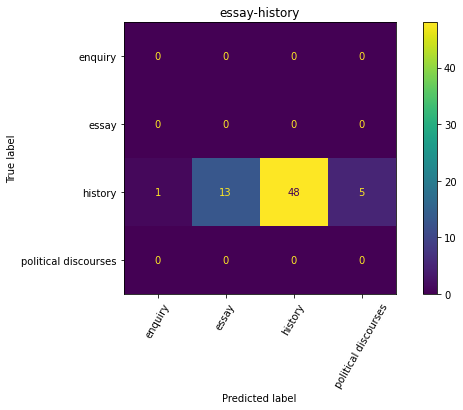

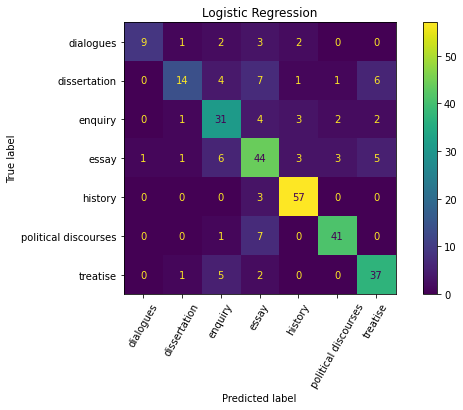

In [10]:
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

In [10]:
feature_extraction(logreg_model, vectorizer, 'logreg')

In [6]:
dataset = import_dataset(13)

In [13]:
sum([len(text.split()) for text in dataset['train']['text']]) + \
sum([len(text.split()) for text in dataset['test']['text']]) + \
sum([len(text.split()) for text in dataset['eval']['text']])

501454

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 2476
    })
    eval: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 309
    })
    test: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 310
    })
})

## Stop-words

Accuracy on essays in history:  0.4477611940298507
Accuracy: 0.7709677419354839%
Training time: 0.8229870796203613 s


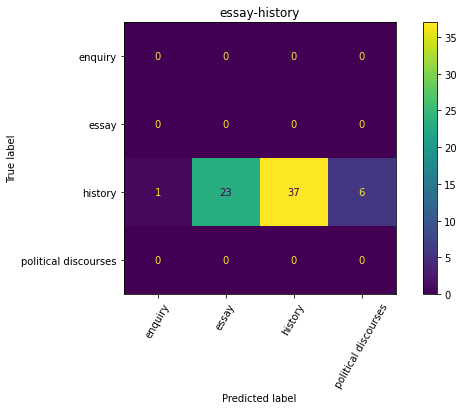

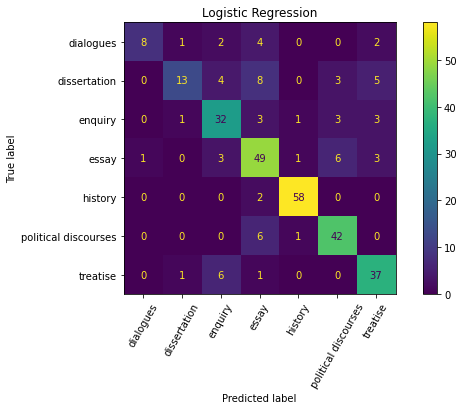

In [10]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

In [12]:
feature_extraction(logreg_model, vectorizer, 'logreg_stopwords')

In [6]:
with open('models/logreg_stopwords.pkl','wb') as f:
    pickle.dump(logreg_model, f)
    
with open('models/tfidf_vectorizer_stopwords.pkl','wb') as f:
            pickle.dump(vectorizer, f)

## N-grams

Accuracy on essays in history:  0.7014925373134329
Accuracy: 0.7258064516129032%
Training time: 1.4512577056884766 s


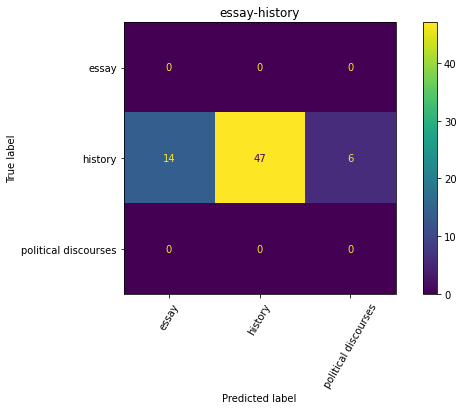

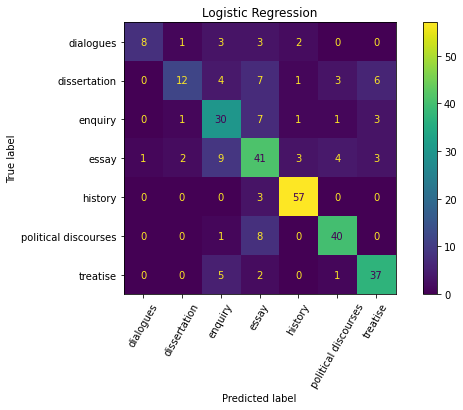

In [9]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.7014925373134329
Accuracy: 0.7258064516129032%
Training time: 1.6398570537567139 s


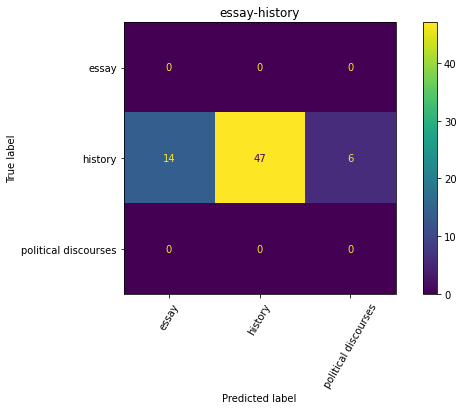

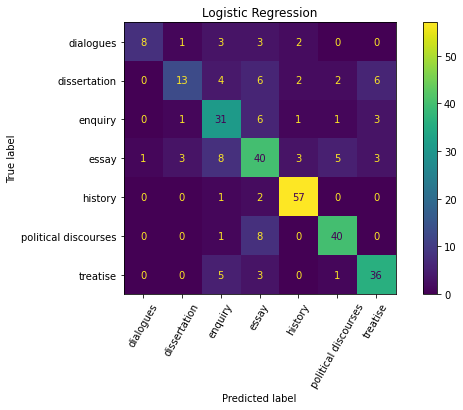

In [10]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.5671641791044776
Accuracy: 0.6161290322580645%
Training time: 1.2675528526306152 s


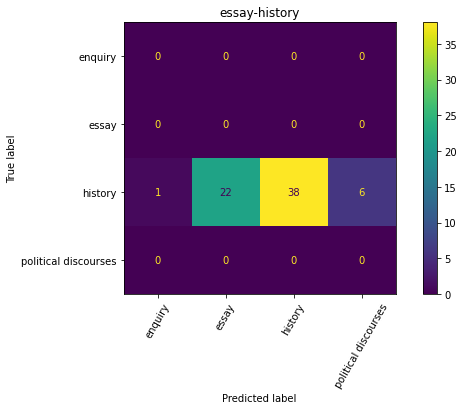

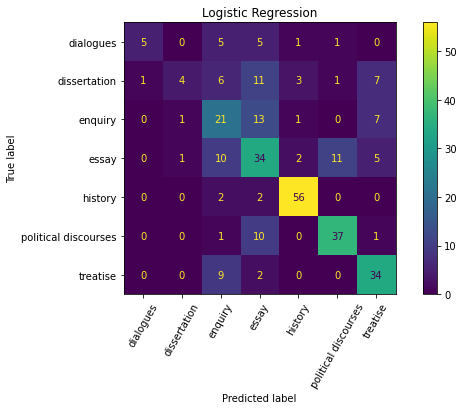

In [11]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2, 2))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.6268656716417911
Accuracy: 0.5774193548387097%
Training time: 14.90951657295227 s


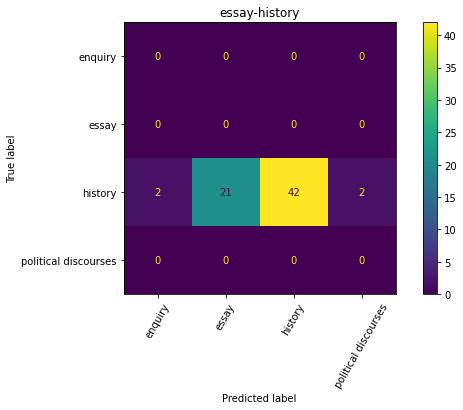

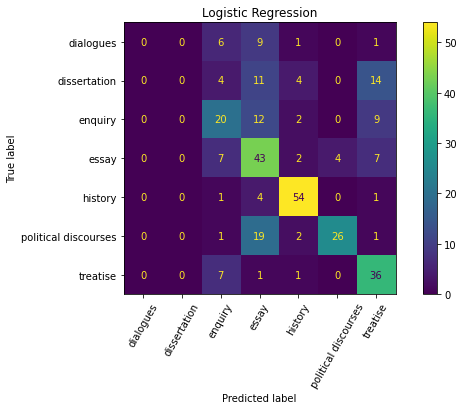

In [54]:
vectorizer = TfidfVectorizer(ngram_range=(3, 3))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

## Char

Accuracy on essays in history:  0.6268656716417911
Accuracy: 0.4096774193548387%
Training time: 0.12454915046691895 s


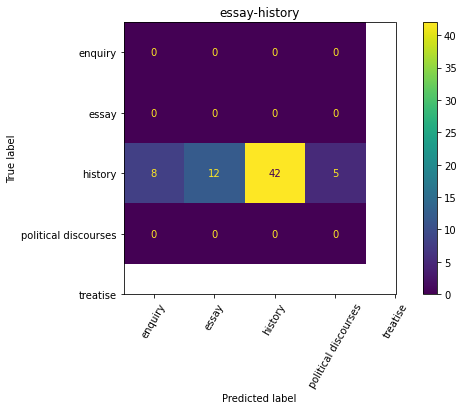

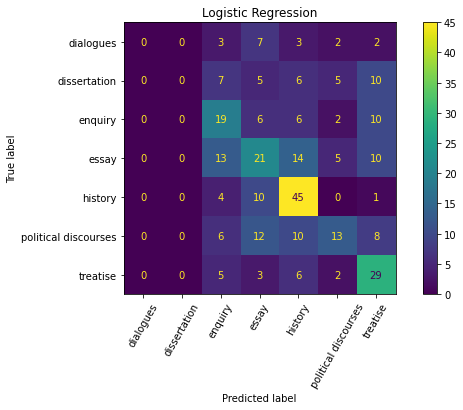

In [12]:
vectorizer = TfidfVectorizer(analyzer='char')
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.6119402985074627
Accuracy: 0.4129032258064516%
Training time: 0.09846711158752441 s


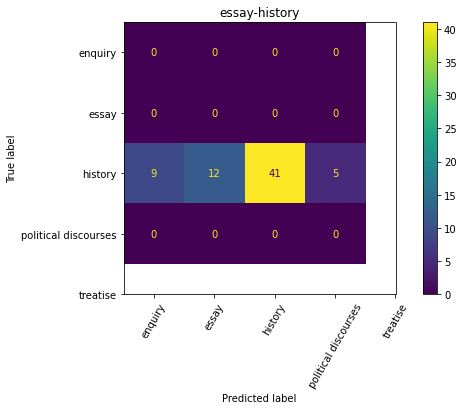

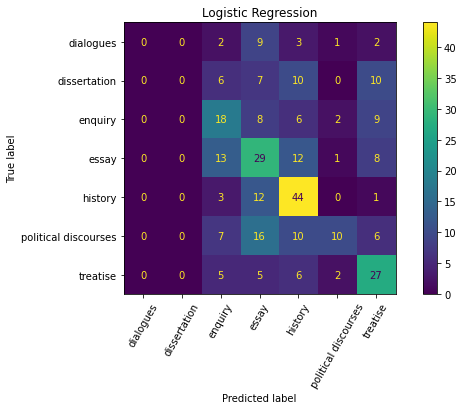

In [13]:
vectorizer = TfidfVectorizer(analyzer='char_wb')
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.7164179104477612
Accuracy: 0.7096774193548387%
Training time: 5.1169562339782715 s


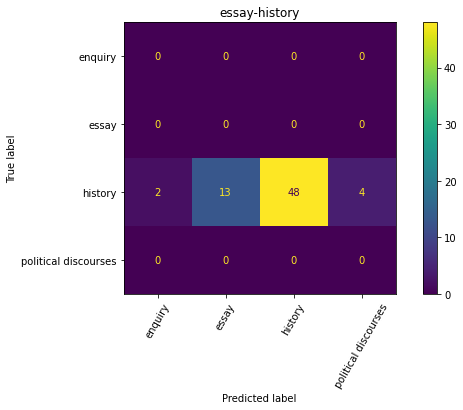

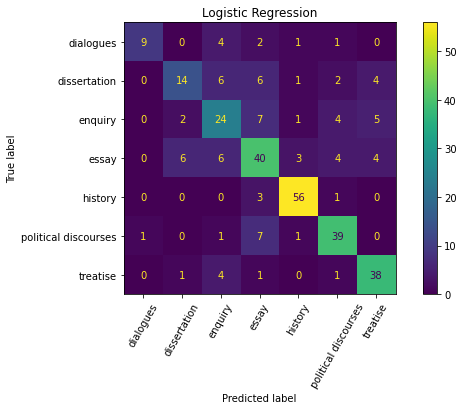

In [14]:
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 3))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.7164179104477612
Accuracy: 0.7387096774193549%
Training time: 6.929611444473267 s


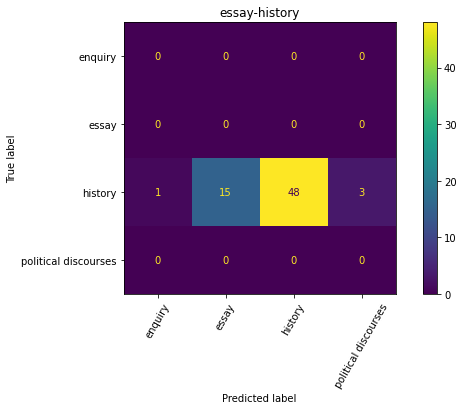

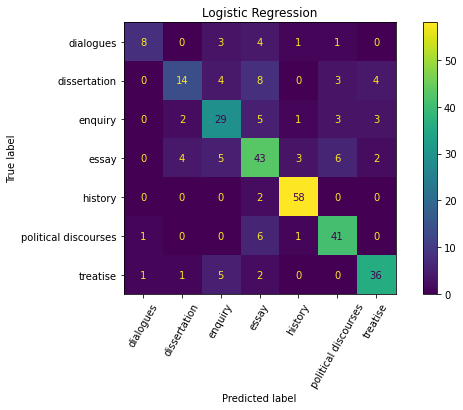

In [52]:
# Laippala 2021
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(4, 4))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

## POS

Accuracy on essays in history:  1.0
Accuracy: 0.31290322580645163%
Training time: 0.10627198219299316 s


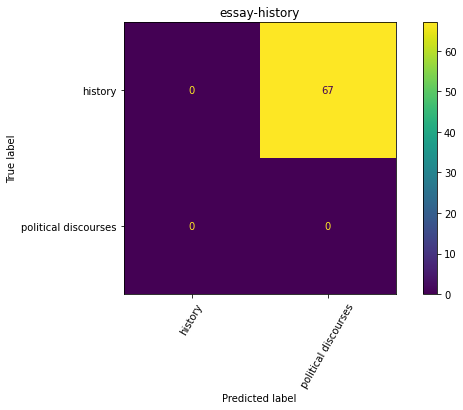

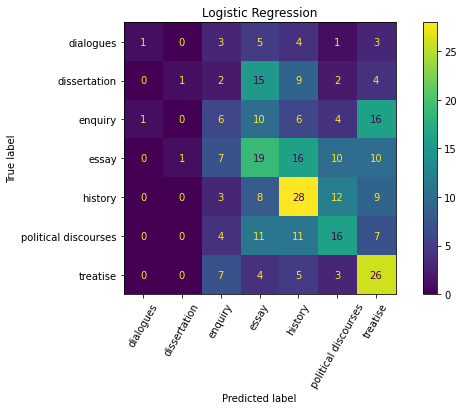

In [11]:
vectorizer = TfidfVectorizer(max_features=5000)
# only pos
data = collect_dataset(13, vectorizer=vectorizer, preproc='pos')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')
feature_extraction(logreg_model, vectorizer, 'pos')

Accuracy on essays in history:  1.0
Accuracy: 0.4096774193548387%
Training time: 0.31237292289733887 s


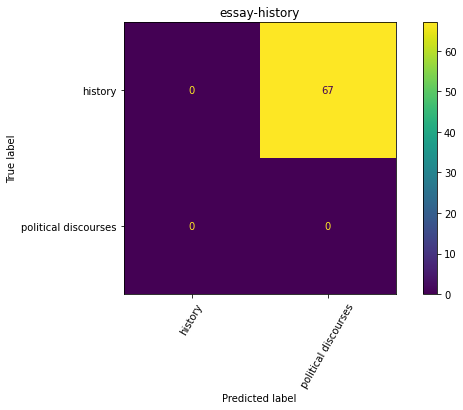

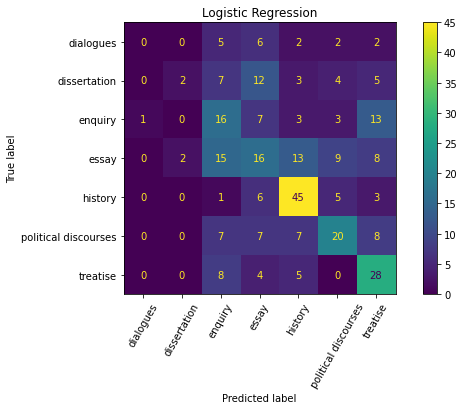

In [12]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
# only pos
data = collect_dataset(13, vectorizer=vectorizer, preproc='pos')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')
feature_extraction(logreg_model, vectorizer, 'pos_ngrams')

Accuracy on essays in history:  0.0
Accuracy: 0.7387096774193549%
Training time: 1.1445198059082031 s


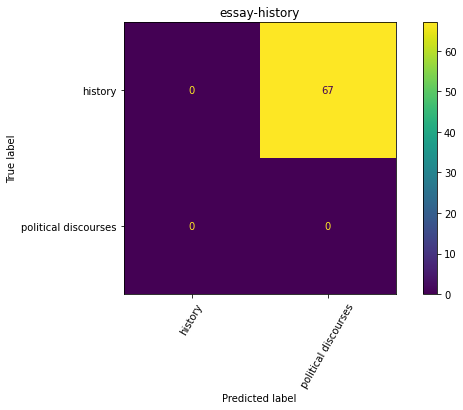

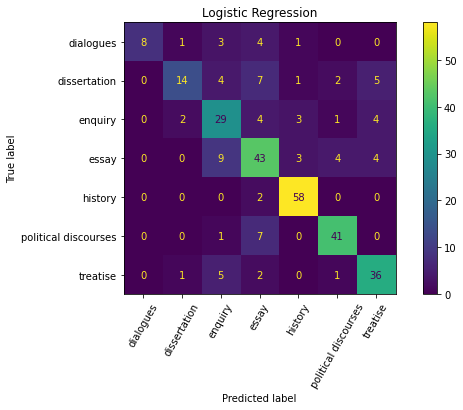

In [16]:
vectorizer = TfidfVectorizer(max_features=5000)
# word_pos
data = collect_dataset(13, vectorizer=vectorizer, preproc='pos_word')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.014925373134328358
Accuracy: 0.7032258064516129%
Training time: 2.3578474521636963 s


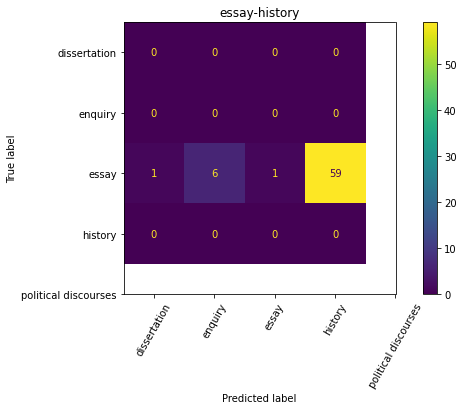

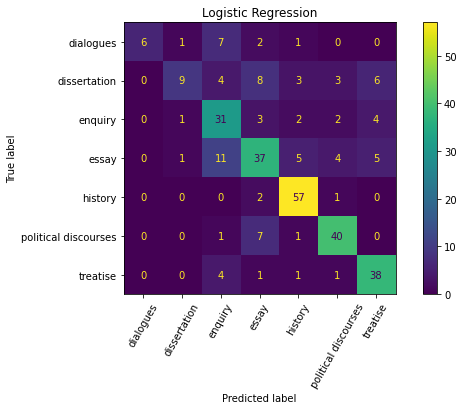

In [109]:
vectorizer = TfidfVectorizer(max_features=5000)
# sentence_tags
data = collect_dataset(13, vectorizer=vectorizer, preproc='pos_sep')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

## NER

Accuracy on essays in history:  0.6716417910447762
Accuracy: 0.7516129032258064%
Training time: 2.632537364959717 s


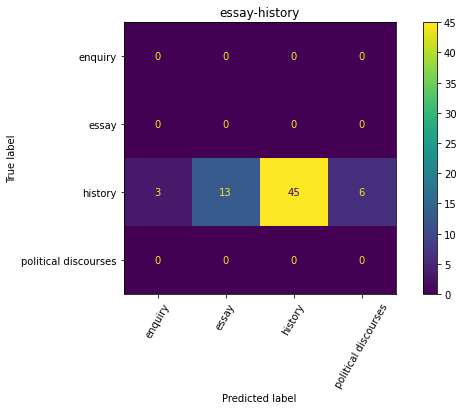

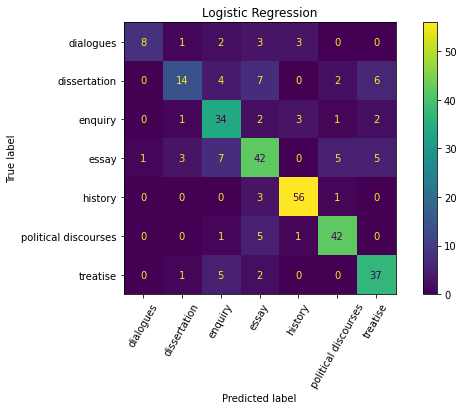

In [15]:
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset(13, vectorizer=vectorizer, preproc='ner')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')
feature_extraction(logreg_model, vectorizer, 'ner')

## Train with EH

In [93]:
def collect_dataset_with_EH(seed, vectorizer=TfidfVectorizer(max_features=5000), save_vect=False, preproc=False):
    
    # returns preprocessed train, test and essays in history test set; trained vectorizer
    
    # main dataset
    dataset = import_dataset(seed)
    
    # essays in history
    eh_dataset = load_dataset('json', data_files='hume_json/essays_in_history.json')

    eh_dataset = eh_dataset['train'].train_test_split(test_size=0.5)

    # это плохо, потму что не совсем понятно, какой лейбл надо указывать (эссе, политический дискурс?)
    # и мы тогда теряем некоторую точность
    def change_labels(example):
        example['labels'] = 3
        example['genre'] = 'essay'
        return example

    eh_dataset['train'] = eh_dataset['train'].map(change_labels)

    final = concatenate_datasets([eh_dataset['train'], dataset['train']])

    y_train = final['labels']
    y_test = dataset['test']['labels']
    
    x_train = final['text']  
    x_test = dataset['test']['text']
    
    
    if preproc=='pos':
        x_train = posify(x_train)
        x_test = posify(x_test)
    elif preproc=='pos_word':
        x_train = posify_word(x_train)
        x_test = posify_word(x_test)
    elif preproc == 'ner':
        x_train = remove_ner(x_train)
        x_test = remove_ner(x_test)
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    # здесь лейбл всё еще история
    x_eh_test = eh_dataset['test']['text']
    y_eh_test = eh_dataset['test']['labels']
    
    x_eh_test = vectorizer.transform(x_eh_test)
#     y_eh_test = y_eh_test
    
    if save_vect:
        with open('models/tfidf_vectorizer.pkl','wb') as f:
            pickle.dump(vectorizer, f)
    
    return x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, vectorizer

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Accuracy on essays in history:  0.5588235294117647
Accuracy: 0.7580645161290323%
Training time: 1.482349157333374 s


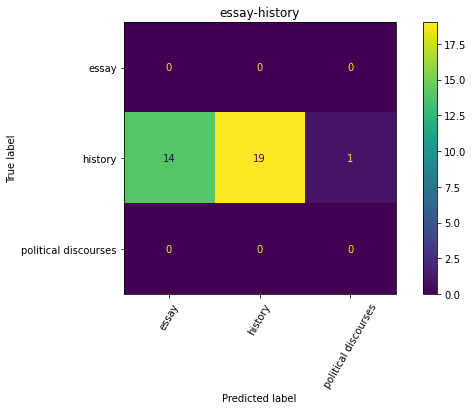

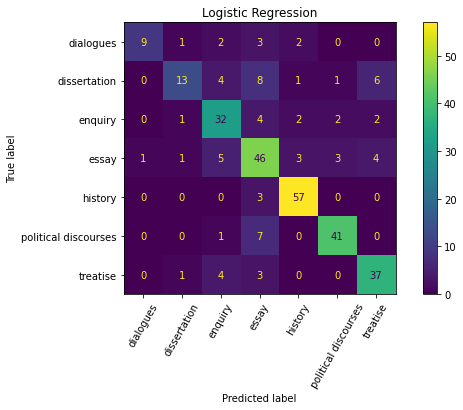

In [94]:
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset_with_EH(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Accuracy on essays in history:  0.3235294117647059
Accuracy: 0.7548387096774194%
Training time: 0.8208303451538086 s


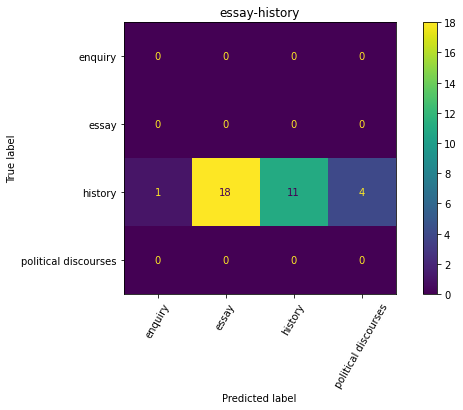

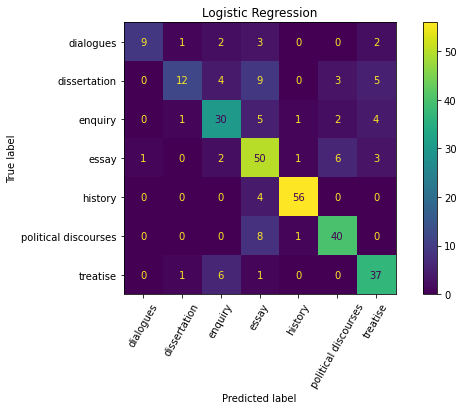

In [95]:
# + remove stop-words
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
data = collect_dataset_with_EH(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

  0%|          | 0/2354 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Accuracy on essays in history:  1.0
Accuracy: 0.4101694915254237%
Training time: 0.1407315731048584 s


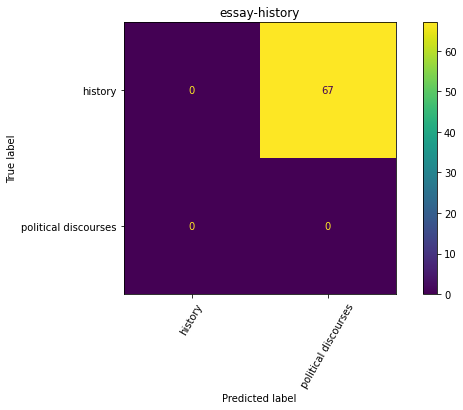

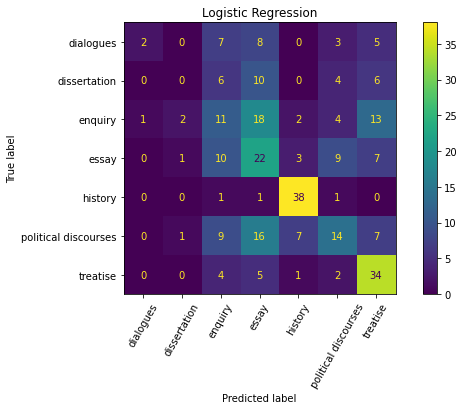

In [16]:
# dependencies
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset(13, vectorizer=vectorizer, preproc='dep', history_data='automatic')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

  0%|          | 0/2354 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

Accuracy on essays in history:  1.0
Accuracy: 0.46440677966101696%
Training time: 0.15226984024047852 s


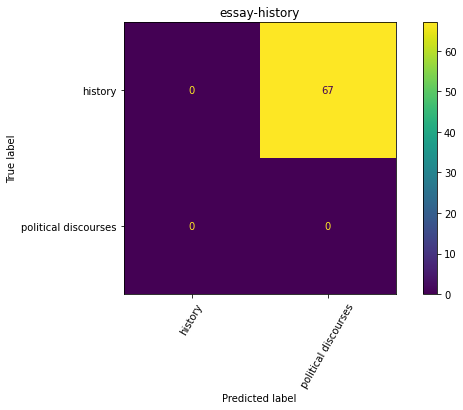

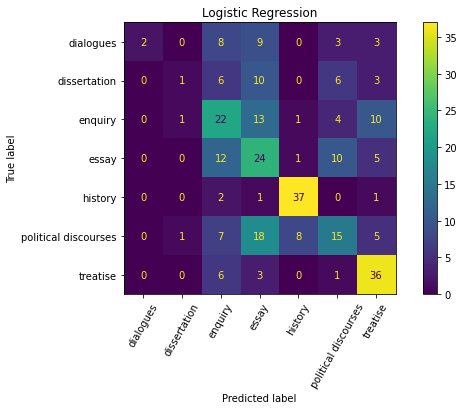

In [23]:
# dependencies+pos
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset(13, vectorizer=vectorizer, preproc='dep_pos', history_data='automatic')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

## New history dataset

Accuracy on essays in history:  0.7313432835820896
Accuracy: 0.752542372881356%
Training time: 1.4515800476074219 s


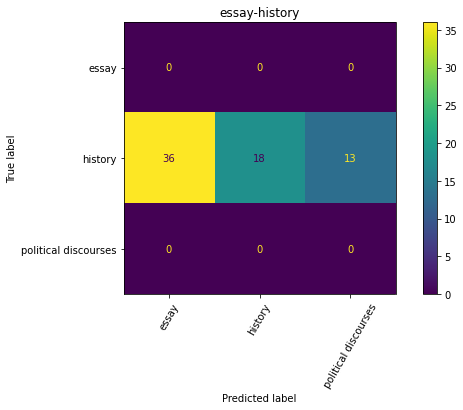

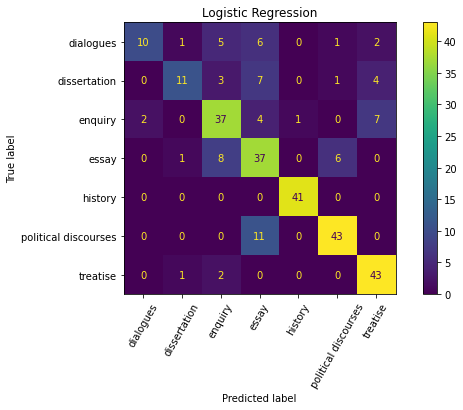

In [13]:
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.8955223880597015
Accuracy: 0.7898305084745763%
Training time: 0.9651651382446289 s


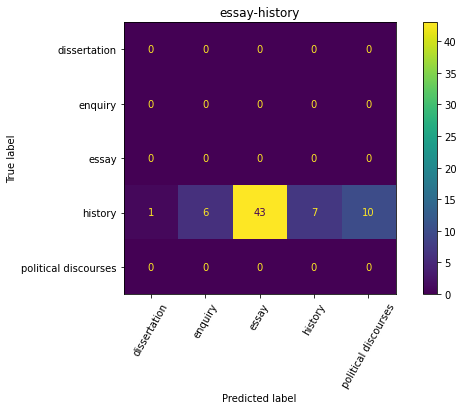

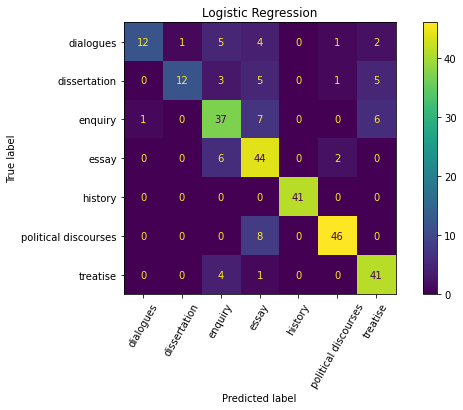

In [14]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.7761194029850746
Accuracy: 0.7898305084745763%
Training time: 1.304779052734375 s


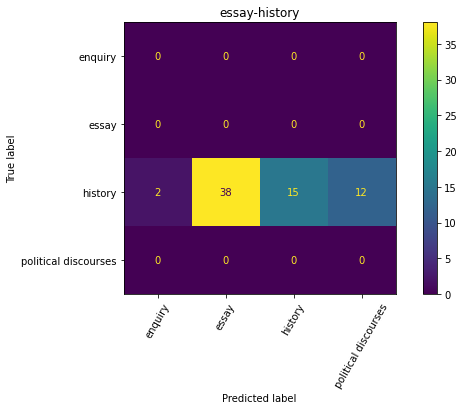

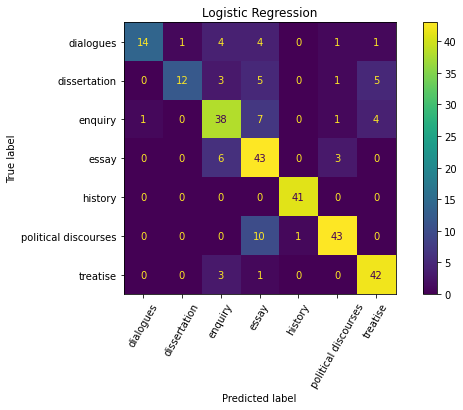

In [11]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords)
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.6417910447761195
Accuracy: 0.5389830508474577%
Training time: 0.6234397888183594 s


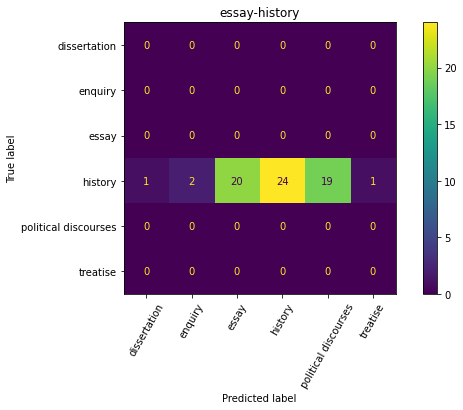

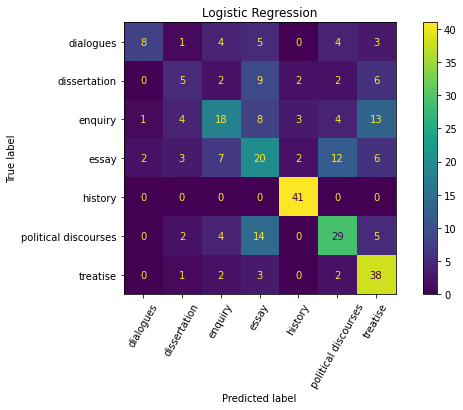

In [25]:
vectorizer = TfidfVectorizer(max_features=5000, vocabulary=stopwords)
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  1.0
Accuracy: 0.39661016949152544%
Training time: 0.261016845703125 s


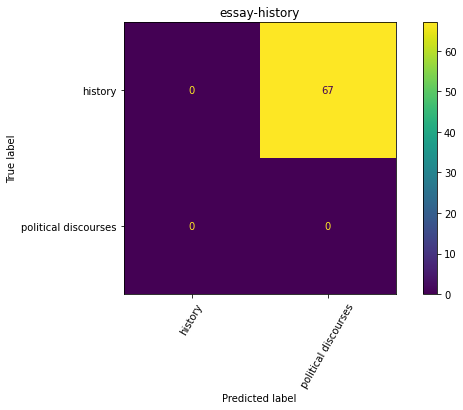

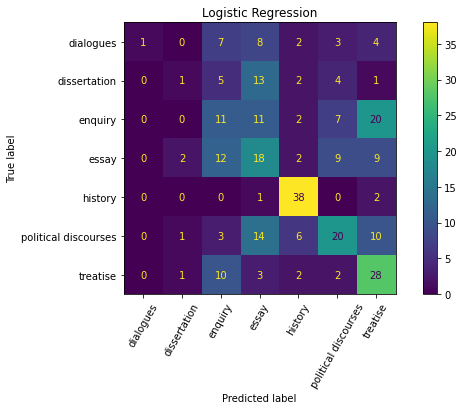

In [24]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic', preproc='pos')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

In [29]:
# bpe
with open('bpe_vocab.txt') as file:
    bpe_vocab = file.read().split('\n')[:-1]

In [36]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("tokenizer-bpe.json")

In [37]:
vectorizer = TfidfVectorizer(max_features=5000, tokenizer=tokenizer, lowercase=False)
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')
feature_extraction(logreg_model, vectorizer, 'bpe')

InvalidParameterError: The 'tokenizer' parameter of TfidfVectorizer must be a callable or None. Got Tokenizer(version="1.0", truncation=None, padding=None, added_tokens=[{"id":0, "content":"[UNK]", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":1, "content":"[CLS]", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":2, "content":"[SEP]", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":3, "content":"[PAD]", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":4, "content":"[MASK]", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}], normalizer=None, pre_tokenizer=None, post_processor=None, decoder=None, model=BPE(dropout=None, unk_token="[UNK]", continuing_subword_prefix=None, end_of_word_suffix=None, fuse_unk=False, byte_fallback=False, ignore_merges=False, vocab={"[UNK]":0, "[CLS]":1, "[SEP]":2, "[PAD]":3, "[MASK]":4, " ":5, "!":6, """:7, "&":8, "'":9, "(":10, ")":11, "*":12, ",":13, "-":14, ".":15, "/":16, "0":17, "1":18, "2":19, "3":20, "4":21, "5":22, "6":23, "7":24, "8":25, "9":26, ":":27, ";":28, "?":29, "A":30, "B":31, "C":32, "D":33, "E":34, "F":35, "G":36, "H":37, "I":38, "J":39, "K":40, "L":41, "M":42, "N":43, "O":44, "P":45, "Q":46, "R":47, "S":48, "T":49, "U":50, "V":51, "W":52, "X":53, "Y":54, "Z":55, "[":56, "]":57, "a":58, "b":59, "c":60, "d":61, "e":62, "f":63, "g":64, "h":65, "i":66, "j":67, "k":68, "l":69, "m":70, "n":71, "o":72, "p":73, "q":74, "r":75, "s":76, "t":77, "u":78, "v":79, "w":80, "x":81, "y":82, "z":83, "{":84, "}":85, "ç":86, "é":87, "ë":88, "ï":89, "ü":90, "—":91, "〈":92, "〉":93, "e ":94, " t":95, " a":96, " th":97, "in":98, ...}, merges=[("e", " "), (" ", "t"), (" ", "a"), (" t", "h"), ("i", "n"), ("e", "r"), ("o", "n"), ("s", " "), ("d", " "), ("e", "n"), (",", " "), ("t", " "), (" th", "e "), ("o", "f"), ("r", "e"), (" a", "n"), ("y", " "), ("o", "r"), ("t", "i"), ("a", "n"), ("t", "h"), ("o", "u"), ("e", "s"), ("o", " "), ("a", "r"), ("h", "i"), ("of", " "), (" an", "d "), ("i", "s"), ("a", "t"), ("in", "g"), ("a", "l"), (".", " "), ("c", "h"), ("ti", "on"), ("i", "t"), ("o", "m"), ("e", "d"), (" t", "o "), ("e", "d "), ("a", "s"), (", ", "w"), ("e", "c"), ("er", " "), (" a", " "), ("l", "l"), ("p", "r"), ("h", "a"), ("i", "s "), ("o", "s"), ("c", "on"), ("s", "u"), ("i", "r"), ("e", "m"), ("en", "t"), ("s", "t"), ("c", "e"), (",", " th"), ("l", "i"), ("s", "i"), ("c", "e "), ("in", " "), ("a", "t "), ("f", "or"), ("ch", " "), ("s", "e"), ("v", "er"), ("i", "th"), ("h", "e "), (",", " and "), ("n", "o"), (" t", "o"), ("b", "l"), ("a", "tion"), ("ing", " "), ("of", " the "), ("v", "e "), ("u", "r"), ("l", "y "), ("e", "x"), ("ou", "r"), ("b", "e"), ("d", "e"), ("m", "a"), ("b", "e "), ("o", "p"), (" an", "d"), ("or", " "), (" th", "e"), ("e", "s "), ("u", "s"), (" ", "w"), ("f", "r"), ("o", "w"), ("hi", "s "), (" a", "r"), ("u", "n"), ("p", "re"), ("er", "e "), ...])) instead.

In [31]:
len(bpe_vocab)

32000

## SVM

In [15]:
from sklearn.svm import SVC, LinearSVC

Accuracy on essays in history:  0.7761194029850746
Accuracy: 0.7796610169491526%
Training time: 5.881911754608154 s


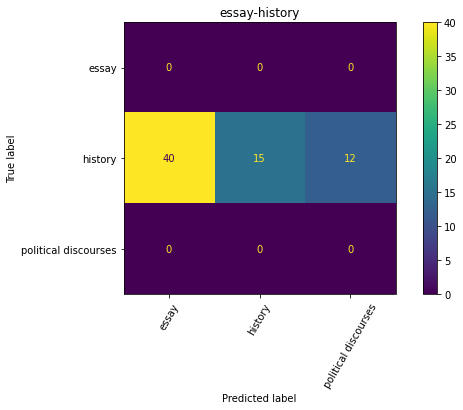

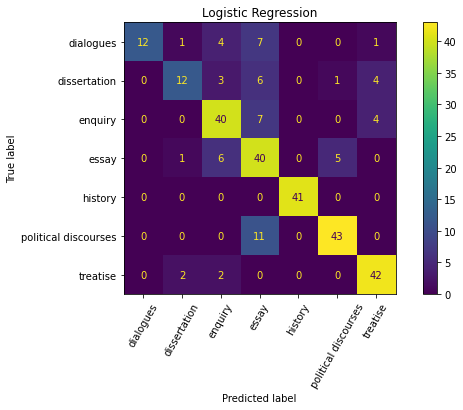

In [16]:
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
model = SVC()
start = time.time()
run_model(model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.9253731343283582
Accuracy: 0.7898305084745763%
Training time: 4.227257251739502 s


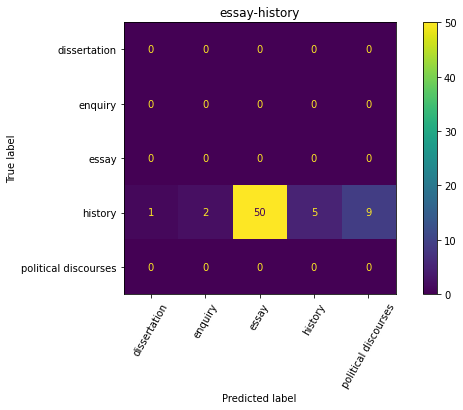

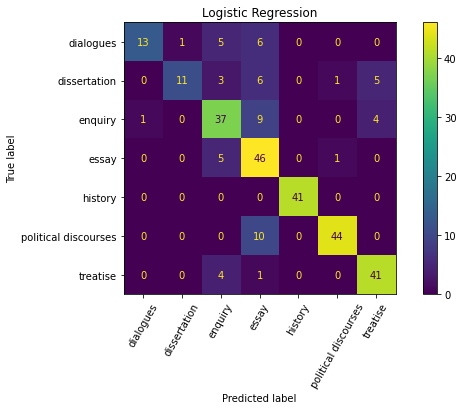

In [17]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
data = collect_dataset(13, vectorizer=vectorizer, history_data='automatic')
model = SVC()
start = time.time()
run_model(model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')